# SENTIMENT ANALYSIS SYSTEM

## IMPORTING THE LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
import nltk

### Downloading necessary NLTK data files

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/palak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/palak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/palak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Initializing NLP tools

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    negations = {"not", "n't", "no"}
    new_tokens = []
    negate = False
    
    for word in tokens:
        if word in negations:
            negate = True
        else:
            if negate:
                new_tokens.append(f"not_{word}")
                negate = False
            else:
                new_tokens.append(word)
    
    return ' '.join(new_tokens)

## IMPORTING THE DATASET

In [10]:
data = pd.read_csv('IMDB_Dataset.csv')

In [11]:
## Loading a sample dataset
dataset = pd.read_csv('IMDB_Dataset.csv', nrows=10000)

## Converting sentiment strings to numeric values

In [13]:
cv = TfidfVectorizer(max_features=2500)
reviews = cv.fit_transform(dataset['review']).toarray()

sentiments = dataset['sentiment'].replace(['positive', 'negative'], [1, 0])

/var/folders/pn/d0x5whnx06nf2m3tybgx7k8w0000gn/T/ipykernel_61822/1831484913.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sentiments = dataset['sentiment'].replace(['positive', 'negative'], [1, 0])


### Verify the conversion

In [15]:
print("After conversion:")
print(dataset)

After conversion:
                                                 review sentiment
0     One of the other reviewers has mentioned that ...  positive
1     A wonderful little production. <br /><br />The...  positive
2     I thought this was a wonderful way to spend ti...  positive
3     Basically there's a family where a little boy ...  negative
4     Petter Mattei's "Love in the Time of Money" is...  positive
...                                                 ...       ...
9995  Fun, entertaining movie about WWII German spy ...  positive
9996  Give me a break. How can anyone say that this ...  negative
9997  This movie is a bad movie. But after watching ...  negative
9998  This is a movie that was probably made to ente...  negative
9999  Smashing film about film-making. Shows the int...  positive

[10000 rows x 2 columns]


In [16]:
dataset['sentiment'].value_counts()

sentiment
positive    5028
negative    4972
Name: count, dtype: int64

### Drop duplicate reviews for a more accurate visualization

In [18]:
dataset = dataset.drop_duplicates(subset='review')

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9983 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     9983 non-null   object
 1   sentiment  9983 non-null   object
dtypes: object(2)
memory usage: 234.0+ KB


In [20]:
dataset.describe()

,review,sentiment
count,9983,9983
unique,9983,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,5023


## Loading a subset of the dataset for training

In [22]:
# Using 10% of the data
dataset_sample = dataset.sample(frac=0.1, random_state=1)

## Visualizing Review Length Distribution by Sentiment

### Add a review length column for visualization

In [26]:
dataset_sample['review_length'] = dataset_sample['review'].apply(len)

### Drop duplicate reviews for a more accurate visualization

In [28]:
unique_sample = dataset_sample.drop_duplicates(subset='review')

## Plotting review length distribution by sentiment

<Figure size 1200x600 with 0 Axes>

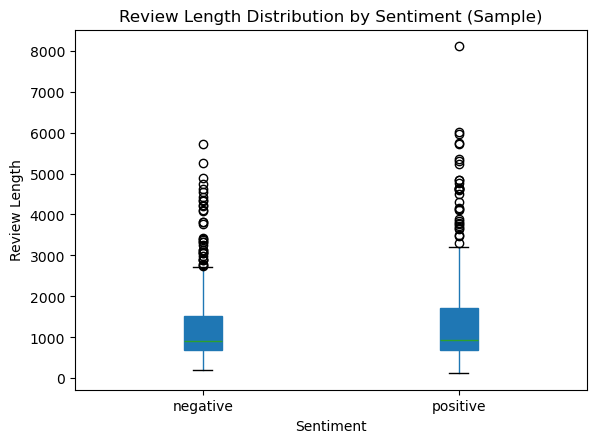

In [32]:
plt.figure(figsize=(12, 6))
unique_sample.boxplot(column='review_length', by='sentiment', grid=False, patch_artist=True)
plt.title('Review Length Distribution by Sentiment (Sample)')
plt.suptitle('')  # Suppressing the default title to avoid duplication
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

In [33]:
# Statistical summary of review length
review_length_summary = unique_sample['review_length'].describe()
print("Review Length Summary:")
print(review_length_summary)

Review Length Summary:
count     998.000000
mean     1287.820641
std       995.249487
min       122.000000
25%       689.000000
50%       921.500000
75%      1631.750000
max      8111.000000
Name: review_length, dtype: float64


### Investigating for Outliers

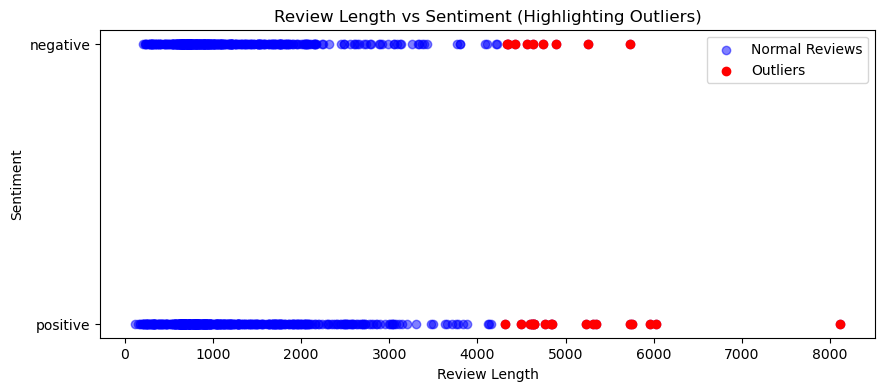

In [35]:
# Define outliers as reviews with lengths greater than 3 standard deviations from the mean
mean_length = unique_sample['review_length'].mean()
std_length = unique_sample['review_length'].std()
outlier_threshold = mean_length + 3 * std_length

# Identify outliers
outliers = unique_sample[unique_sample['review_length'] > outlier_threshold]

# Plot
plt.figure(figsize=(10, 4))
plt.scatter(unique_sample['review_length'], unique_sample['sentiment'], alpha=0.5, c='blue', label='Normal Reviews')
plt.scatter(outliers['review_length'], outliers['sentiment'], color='red', label='Outliers')
plt.title('Review Length vs Sentiment (Highlighting Outliers)')
plt.xlabel('Review Length')
plt.ylabel('Sentiment')
plt.legend()
plt.show()

#### Summary of outliers

In [51]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = unique_sample['review_length'].quantile(0.25)
Q3 = unique_sample['review_length'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = unique_sample[(unique_sample['review_length'] < lower_bound) |
                          (unique_sample['review_length'] > upper_bound)]

# Print summary of outliers
print("Outliers Summary:")
print(outliers['review_length'].describe())

Outliers Summary:
count      63.000000
mean     4204.841270
std       958.732601
min      3051.000000
25%      3409.000000
50%      4117.000000
75%      4642.500000
max      8111.000000
Name: review_length, dtype: float64


## ANALYZING THE FIRST REVIEW

#### To better understand what cleaning steps to undertake

In [55]:
dataset['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## CLEANING THE TEXTS

### Applying cleaning function to 'review' column

In [59]:
dataset['cleaned_review'] = dataset['review'].apply(clean_text)

/var/folders/pn/d0x5whnx06nf2m3tybgx7k8w0000gn/T/ipykernel_61822/131149454.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


### Visualizing the Sentiment Distribution

In [61]:
sentiment_counts = unique_sample['sentiment'].value_counts()

### Plotting the sentiment distribution

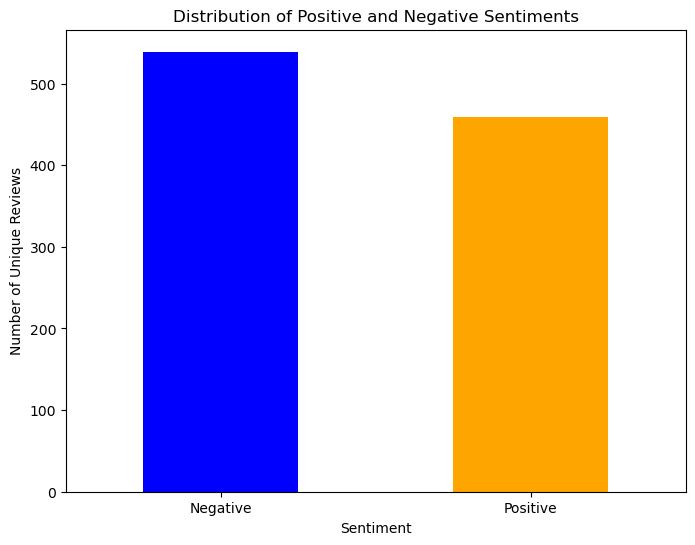

In [63]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Positive and Negative Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Unique Reviews')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

### Proportion of positive and negative reviews

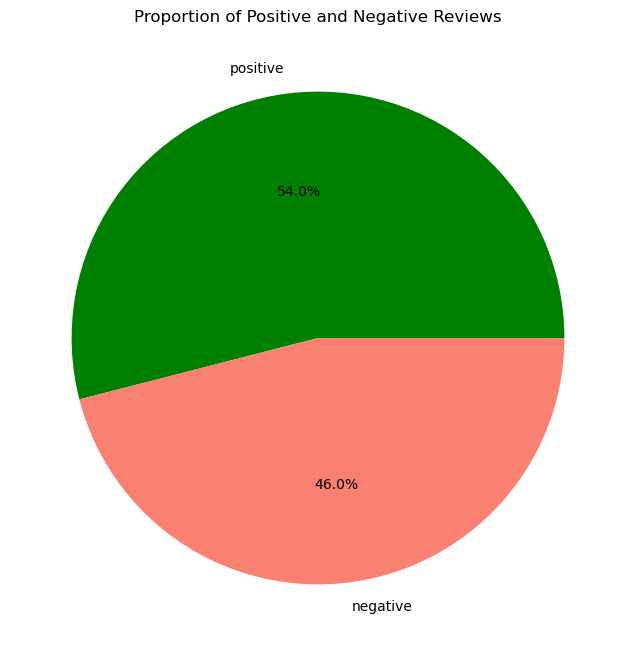

In [65]:
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'salmon'])
plt.title('Proportion of Positive and Negative Reviews')
plt.show()

## Word Cloud VISUALIZATION

#### Positive Word Cloud : only unique reviews

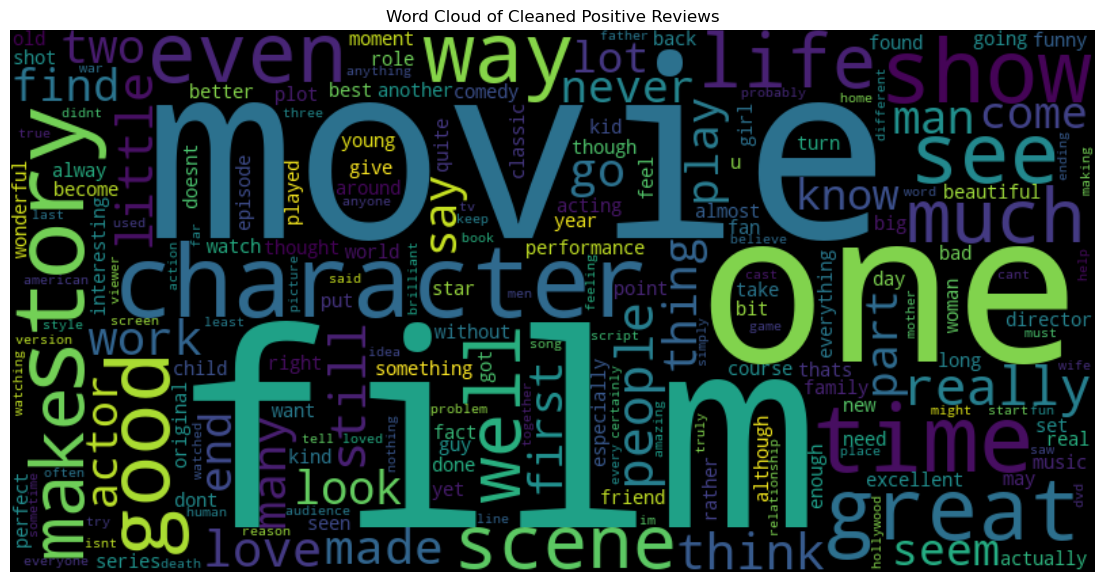

In [68]:
from wordcloud import WordCloud

# Filter for positive cleaned reviews
positive_reviews = dataset[dataset['sentiment'] == 'positive']

# Combine all cleaned positive reviews into a single string
positive_cleaned_text = ' '.join(positive_reviews['cleaned_review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(positive_cleaned_text)

# Display the word cloud
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Positive Reviews')
plt.show()

#### Negative Word Cloud : only unique reviews

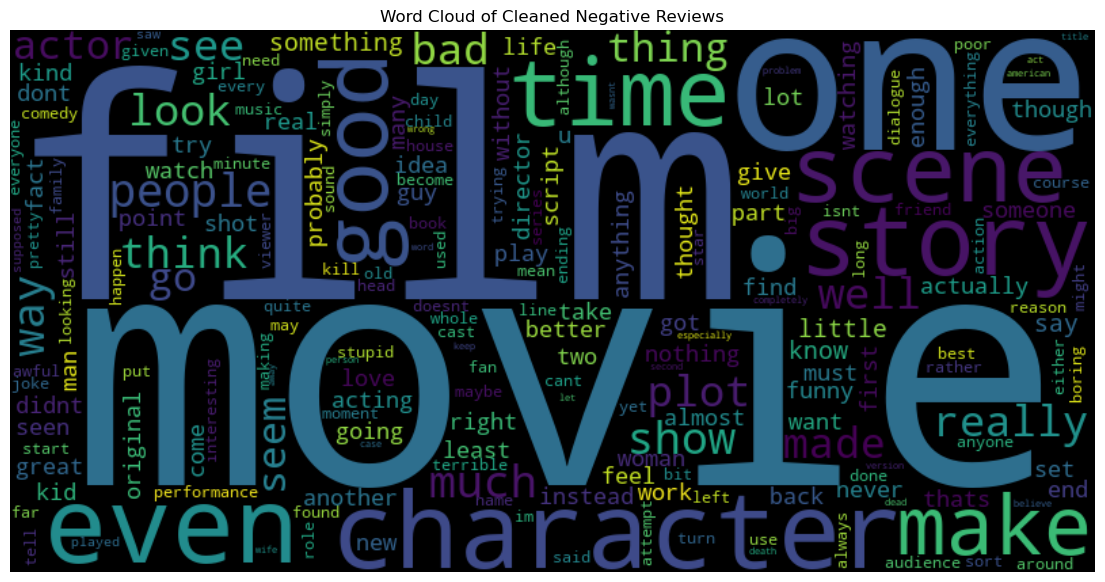

In [70]:
# Filter for negative reviews
negative_reviews = dataset[dataset['sentiment'] == 'negative']

# Combine all cleaned negative reviews into a single string
negative_text = ' '.join(negative_reviews['cleaned_review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

# Plot the word cloud
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for the word cloud
plt.title('Word Cloud of Cleaned Negative Reviews')
plt.show()

# Creating the Bag of Words model

In [72]:
sentiments

0       1
1       1
2       1
3       0
4       1
       ..
9995    1
9996    0
9997    0
9998    0
9999    1
Name: sentiment, Length: 10000, dtype: int64

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000)  # Reduce the number of features
x = reviews
y = sentiments

In [78]:
# len(x[0])

In [80]:
# Verify the shape of the feature matrix and labels
print(f"Feature matrix shape: {x.shape}")
print(f"Labels shape: {y.shape}")

# Example output
print(f"First few features: {x[:5]}")
print(f"First few labels: {y[:5]}")

Feature matrix shape: (10000, 2500)
Labels shape: (10000,)
First few features: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.07867084 0.         ... 0.         0.28106919 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
First few labels: 0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64


# Splitting the dataset into the Training set and Test set

In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [89]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
y_train

7681    0
9031    0
3691    0
202     1
5625    0
       ..
9225    1
4859    1
3264    0
9845    1
2732    1
Name: sentiment, Length: 7000, dtype: int64

# TRAINING THE MODELS ON TRAINING SET

#### DECISION TREE REGRESSION

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=0)

# Fit the model with the training data
classifier.fit(x_train, y_train)

# Make predictions
y_pred = classifier.predict(x_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.694
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1495
           1       0.69      0.70      0.70      1505

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000



#### MULTIPLE LINEAR REGRESSION

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
classifier = LogisticRegression()

# Train the model on the training set
classifier.fit(x_train, y_train)

# Predict the Test set results
y_pred = classifier.predict(x_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.867
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1495
           1       0.85      0.90      0.87      1505

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



#### RANDOM FOREST

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=0)

# Train the model
rf.fit(x_train, y_train)

# Predict the Test set results
y_pred = rf.predict(x_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.7453333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1495
           1       0.78      0.68      0.73      1505

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.74      3000
weighted avg       0.75      0.75      0.74      3000



#### SUPPORT VECTOR REGRESSION [SVR]

In [104]:
from sklearn.svm import SVC  # Import the correct model for classification
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Support Vector Classification model
classifier = SVC(kernel='rbf')  # Using the RBF (Radial Basis Function) kernel

# Fit the model on the training data
classifier.fit(x_train, y_train)

# Predict the test set results
y_pred = classifier.predict(x_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.869
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1495
           1       0.85      0.90      0.87      1505

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



#### RNN MODEL

In [107]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.preprocessing.sequence import pad_sequences

# Define constants
MAX_NB_WORDS = 2500
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Assume x_train, x_test, y_train, y_test are already prepared
# x_train, x_test should be padded sequences
# y_train, y_test should be the labels (0 or 1)

# Define the RNN model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SimpleRNN(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"RNN Model Accuracy: {accuracy:.4f}")

# Save the model
model.save('rnn_model.h5')


Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 591ms/step - accuracy: 0.4974 - loss: 0.6937 - val_accuracy: 0.4714 - val_loss: 0.6938
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 598ms/step - accuracy: 0.4934 - loss: 0.6934 - val_accuracy: 0.4714 - val_loss: 0.6940
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 587ms/step - accuracy: 0.4997 - loss: 0.6933 - val_accuracy: 0.4714 - val_loss: 0.6934
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 591ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5286 - val_loss: 0.6923
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 586ms/step - accuracy: 0.4991 - loss: 0.6933 - val_accuracy: 0.4714 - val_loss: 0.6936
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.4989 - loss: 0.6932


RNN Model Accuracy: 0.4983


#### LOGISTIC REGRESSION

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = LogisticRegression()
model.fit(x_train, y_train)

# Predict the Test set results
predict = model.predict(x_test)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, predict)}")
print(f"Classification Report:\n{classification_report(y_test, predict)}")

Accuracy: 0.867
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1495
           1       0.85      0.90      0.87      1505

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



## CORRECTING THE DATA FORMAT

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import joblib

# Example training data (ensure these are strings)
X_train = ["I love this product", "This is the worst purchase ever", "Fantastic quality and service", "I am not happy with the product"]
y_train = [1, 0, 1, 0]  # Example labels: 1 for positive, 0 for negative

# Create and fit the vectorizer
cv = CountVectorizer()
X_train_vectors = cv.fit_transform(X_train)  # X_train should be a list of strings

# Train the model
classifier = SVC()
classifier.fit(X_train_vectors, y_train)

# Save the vectorizer and model
joblib.dump(classifier, 'svm_model.pkl')
joblib.dump(cv, 'count_vectorizer.pkl')


['count_vectorizer.pkl']

## Loading and Using the Model and Vectorizer

In [ ]:
import joblib
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data files if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define the text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    negations = {"not", "n't", "no"}
    new_tokens = []
    negate = False
    
    for word in tokens:
        if word in negations:
            negate = True
        else:
            if negate:
                new_tokens.append(f"not_{word}")
                negate = False
            else:
                new_tokens.append(word)
    
    return ' '.join(new_tokens)

# Load the trained model and vectorizer
classifier = joblib.load('svm_model.pkl')
cv = joblib.load('count_vectorizer.pkl')

# Define the function to predict sentiment of a new review
def predict_sentiment(review):
    cleaned_review = clean_text(review)
    review_vector = cv.transform([cleaned_review])  # Ensure this is a list of strings
    prediction = classifier.predict(review_vector)
    sentiment = "positive" if prediction[0] == 1 else "negative"
    return sentiment

# Take user input for a new review
new_review = input("Enter a review: ")
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")


[nltk_data] Downloading package punkt to /Users/palak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/palak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/palak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
